# ISVR1032 Acoustics I
## Plucking strings
### Matthew Wright mcmw@isvr.soton.ac.uk

In [1]:
%pylab inline
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In the last notebook we noted that a string obeying the wave equation

$$ 
\frac{\partial^2 y}{\partial x^2} - \frac{1}{c^2}\frac{\partial^2 y}{\partial t^2} = 0,
$$

has a general solution of the form

$$
y(x,t) = y_+(x - ct) + y_-(x + ct).
$$

and that the relationship between $y_+(\cdot)$ and $y_-(\cdot)$ is determined by the initial and boundary conditions. In particular we showed that for a stationary initial condition each component becomes half that initial function. We also showed that a fixed boundary condition causes a wave to be reflected with inverted polarity and reversed direction. In this notebook we shall use these two facts to predict the motion of a plucked string of finite length.

We shouldn't expect the results to be perfectly realistic for a number of reasons. Firstly the assumptions necessary to derive the simple wave equation are not fully justified for, say, a guitar string. Anyone who's accidentally poked themselves in the eye with a guitar string knows that the flexural stiffness is non-zero, and we can observe that the string's vibrations rarely remain in one plane indefinitely.  This doesn't make the exercise pointless, but we should be realistic in our expectations of the results.

We will make further assumptions when modelling the boundary and initial conditions which aren't perfectly justified. Taking boundary conditions first, the ends of a guitar string aren't perfectly rigid - in an acoustic instrument the vibration of the bridge is essential to the transmission of energy to the body of the instrument and the radiation of sound. Even on an electric instrument the bridge isn't perfectly rigid. Nonetheless we'll specify this for our model so

$$
y(0,t) = 0,\qquad y(L, t)=0
$$

where $L$ is the length of the string. We'll refer to $x = 0$ and $x = L$ as the bridge and the nut respectively.

What about modelling the pluck? A plucked string doesn't always start from an exactly stationary state, but that's what we'll model:

$$
y(x,0) = y_0(x) \qquad \frac{\partial y}{\partial t}(x,0) = 0;
$$

Obviously our initial condition must satisfy the boundary conditions so we'll require

$$
y_0(0) = y_0(L) = 0
$$

We know that the details of the plectrum/finger interaction make a difference to the sound. We'll simplify considerably by saying the string starts from a stationary trianguar shape with just two parameters: $\beta$, where $x = \beta L$ is the plucking point, and $A$ its displacement that point. For the simplest possible plucking shape we have

$$
y_0(x) = \begin{cases} 
   \displaystyle \frac{Ax}{\beta L} , & 0\le x < \beta L \\
   \displaystyle \frac{A(L-x)}{(1-\beta)L}, & \beta L <x \le L.
\end{cases}
$$

We can code this as follows. Note that applying a logical condition to a NumPy array returns an array of 1s and 0s corresponding to the elements that do and do not satisfy the condition.

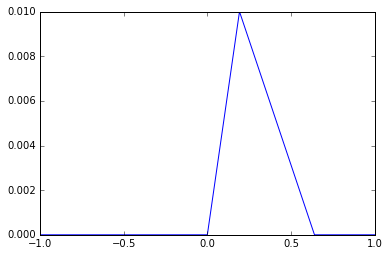

In [2]:
def y0(x):
    return (A/L)*((x/beta)*(x >= 0)*(x < beta*L) + (L - x)/(1 - beta)*(x >= beta*L)*(x <= L))

L = 0.64   # Stratocaster scale length
A = 0.01
beta = 0.3

x = linspace(-1, 1, 1000)

plot(x, y0(x))

If the string were infinitely long we'd just make $y_+(x) = y_-(x) = {\textstyle\frac{1}{2}}y_0(x)$ and proceed as usual. But because the boundary conditions induce reflections we need to include the virtual reflected waves in $y_+$ and $y_-$. In the previous notebook we had one reflecting boundary condition and one virtual wave, just like having one mirror gives you one image of yourself. Now that we've got a reflecting boundary conition at each end of the string it's like standing between mirrors on opposite walls of a room - you'll see an infinite series of reflections in each direction.

In order to achieve this with the string we need to construct an infinitely repeated version of $y_0(x)$ which we'll call $y_\infty$. Between $x = 0$ and $x=L$ we'll have $y_\infty(x) = y_0(x)$. Outside this interval it will consist of copies of $y_0(x)$ reversed in polarity and direction. Reversing polarity and direction twice returns the function to its original shape, so the function will be **periodic** with period $2L$. [It's more common to encounter functions that are periodic in time, but in this problem we'll encounter both kinds of periodicity.] We therefore have:

$$
y_\infty(x) = \begin{cases}
y_0(x)       & 0 \le x \le L,\\
-y_0(2L-x)   & L < x \le 2L, \\
-y_\infty(-x) & x < 0, \\
y_\infty(x - 2L) & x > 2L.
\end{cases}
$$
  
This is a *recursive* definition: the function is defined in terms of itself. As long as this doesn't lead to *infinite* recursion it's unambiguous, and we can do the same in Python if we want:

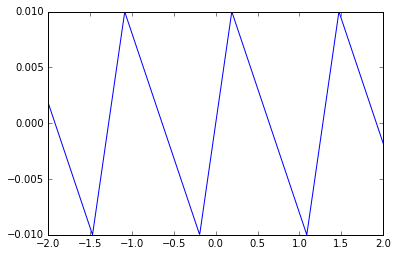

In [3]:
def y_inf_scalar(x):
    if 0 <= x <= L:
        return y0(x)
    elif L < x <= 2*L:
        return -y0(2*L - x)
    elif x < 0:
        return -y_inf_scalar(-x)
    elif x > 2*L:
        return y_inf_scalar(x - 2*L)
    
y_inf = vectorize(y_inf_scalar)

x = linspace(-2, 2, 1000)
plot(x, y_inf(x))

Recursion can be a very effective programming technique, but if `y_inf()` is called with a very large argument then the last branch of the `if` will be called many times before enough lots of $2L$ have been subtracted for one of the non-recursive branches to be called. It is therefore probably more efficient to take advantage of the periodicity like this:

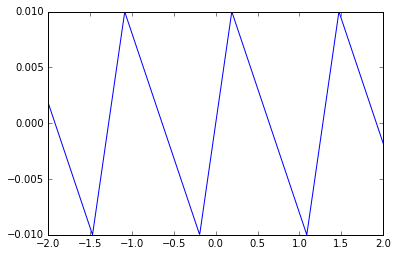

In [4]:
def y_inf_scalar(x):
    x = mod(x, 2*L)
    if 0 <= x <= L:
        return y0(x)
    elif L < x <= 2*L:
        return -y0(2*L - x)
    
y_inf = vectorize(y_inf_scalar)

x = linspace(-2, 2, 1000)
plot(x, y_inf(x))

With this definition we can set

$$
y(x,t) = {\textstyle\frac{1}{2}} [y_\infty(x - ct) + y_\infty(x + ct)]
$$

and simulate the string's motion. As before, we'll plot both the finite string and (2cm lower) the infinite virtual waves, and place dots at the ends of the string in both cases. We won't set the axis to have qual units so the displacement of the string will be exaggerated. We'll specify values for the string's tension and mass per unit length and calculate the wave speed from that.

We'll switch to external graphics windows for the animations.

In [5]:
%matplotlib

Using matplotlib backend: Qt4Agg


In [7]:
def y(x, t):
    return (y_inf(x - c*t) + y_inf(x + c*t))/2

tau = 100        # 100 Newtons tension
mu = 0.001       # 1 gramme per metre
c = sqrt(tau/mu)

xs = linspace(0, L, 500)      # String 0 to L
x = linspace(-1, 2, 1000)     # Extended domain

movie = []                             
fig, ax = subplots()
for t in linspace(0, 2*L/c, 50):           
    frame = ax.plot(xs, y(xs, t) + 0.02, 'm',               # Actual string       
                    x, y_inf(x - c*t)/2, 'r',               # Right-going wave
                    x, y_inf(x + c*t)/2, 'b',               # Left-going wave
                    [0, 0, L, L], [0, 0.02, 0, 0.02], 'ro') # Dots
    movie.append(frame)                 
    
ani = animation.ArtistAnimation(fig, movie, interval=100)     
fig.show() 

#### Exercises
1. The animation jumps because the time interval over which solutions are calculated, 0.01 s, does not correspond to a whole number of time periods of the string's motion. How far do the virtual waves travel in a time period? Use your answer to this question to find an expression for the time period and use that to make the motion smooth.
2. Write down an expression for the string's frequency of vibration in terms of $L$, $\tau$ and $\mu$.
2. Plot $y(x,t)$ as a static surface for two time periods. How does the surface change if $\beta$ changes?

## Realism and sound

In the class we'll look at some  video clips of plucked strings taken with a high-speed camera  and discuss the similarities and differences between the predictions of our simplified model and observations of real strings. One important difference that we can already notice is that our model string keeps vibrating indefinitely, whereas real string vibrations decay - we haven't modelled any mechanism whereby energy can leave the string.

Interesting though it is to observe the string's motion we're probably more interested in the sound it makes. In an acoustic guitar the force that the string exerts on the bridge depends on the angle it's at. Run the animation again and observe how this angle determines when the string is pulling upwards (in our axes) and when it's pulling down.

The component of force the bridge experiences perpendicular to the front of the instrument is 

$$
\tau \sin\theta(0,t) \approx \tau \frac{\partial y}{\partial x}(0,t),
$$ 

by the same small-amplitude assumption we made when deriving the wave equation. The string's gradient is

$$
\begin{align}
\frac{\partial y}{\partial x}(x,t) &= \frac{1}{2}\frac{\partial}{\partial x}[y_\infty(x - ct) + y_\infty(x + ct)] \\
&=y'_\infty(x - ct) + y'_\infty(x + ct)
\end{align}
$$

so

$$
\frac{\partial y}{\partial x}(0,t) = {\textstyle\frac{1}{2}} [y'_\infty(-ct) + y'_\infty(ct)]
$$

where

$$
y'_0(x) = \begin{cases} 
   \displaystyle \frac{A}{\beta L} , & 0\le x < \beta L \\
   \displaystyle \frac{-A}{(1-\beta)L}, & \beta L <x \le L.
\end{cases}
$$

We can find $y'_\infty(x)$ in terms of $y_0$, using the chain rule where necessary:

$$
y'_\infty(x) = \begin{cases}
y'_0(x \bmod 2L)       & 0 \le (x \bmod 2L) \le L,\\
y'_0[2L-(x \bmod 2L)]   & L < (x \bmod 2L) \le 2L, \\
\end{cases}
$$

We'll code $y'_\infty(x)$ and plot it along with $y_\infty(x)$ to make sure this definition works, switching back to inline figures. 

In [ ]:
%matplotlib inline

In [ ]:
def y0_dash(x):
    return (A/L)*((1/beta)*(x >= 0)*(x < beta*L) - 
                  1/(1 - beta)*(x >= beta*L)*(x <= L))

def y_inf_dash_scalar(x):
    x = mod(x, 2*L)
    if 0 <= x <= L:
        return y0_dash(x)
    elif L < x <= 2*L:
        return y0_dash(2*L - x)
    
y_inf_dash = vectorize(y_inf_dash_scalar)

x = linspace(-2, 2, 1000)

plot(x, y_inf_dash(x), x, y_inf(x))

With this definition we can plot the time history of the force for two values of $\beta$ (i.e. two different plucking points).

In [ ]:
t = linspace(0, 0.015, 1000)
beta = 0.2
plot(t, (y_inf_dash(c*t) + y_inf_dash(-c*t))/2)
beta = 0.4
plot(t, (y_inf_dash(c*t) + y_inf_dash(-c*t))/2)
xlabel('Time (s)')
ylabel('Force (N)')
legend(('beta = 0.2', 'beta = 0.4'))

#### Exercises
1. An electric guitar has scale length 640 mm, and string gauges 10, 13, 17, 26, 36, 42 (diameters in thousandths of an inch).  The top three strings are plain (bulk density $7900\,\mbox{kg}\,\mbox{m}^{-3}$), the bottom three are wound ($6800\,\mbox{kg}\,\mbox{m}^{-3}$). What is the total force on the bridge?
2. The output of an electric guitar pickup a distance $\alpha L$ from the bridge is proportional to the velocity with which the string moves past it. Plot this output for our string and explore how it varies with both $\alpha$ and $\beta$.

## Summary

[Edit this cell to summarise the important points from this notebook]